# Tarea 1

## 0. Bibliotecas y Datasets
--- 

In [78]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url

In [3]:
# Conjunto de datos de calificaciones Para el ejercicio 2
# directorio de datos
URL_califs = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv'
base_dir = './'
filename_califs = 'califs.csv'
filepath_califs = os.path.join(base_dir, filename_califs)
download_url(URL_califs, base_dir, filename_califs)

## 1. Red de unidades de umbral lineal
---

Programa y evalúa una red de neuronas con funciones de activación escalón unitario que aproxime la operación **XNOR** dada por:

| $x_1$  | $x_2$  |  $y$ |
|---|---|---|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |


### Función escalón

In [4]:
def escalon(z):
    # En la función escalon utilizamos un umbral como límite para regresar
    #   0 o 1
    if z > 0.0:
        return 1.0
    
    return 0.0

### Red Neuronal

En la función multicapa se obtienen los valores resultantes de 2 capas de neuronas.
En este caso la primer capa constara de 2 neuronas cada una aproximando las compuertas NOR y AND.
La segunda y última capa aproxima una compuerta OR, siendo las 2 entradas las salidas de la capa anterior.
La salida de la segunda capa será la salida de toda la red siendo la aproximación de XNOR en conjunto.

In [5]:
def multicapa(x, W1, b1, W2, b2):
  escv = np.vectorize(escalon)
  a = escv(np.dot(W1.T, x) + b1)
  return escv(np.dot(W2.T, a) + b2)

### Valores de entrada y pesos

In [6]:
# Los valores de entrada corresponden a la tabla de valores binarios
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])

# Capa 1.
#   Pesos
W1 = np.array([
               # NOR_1, AND_1
               [-1, 1],
               
               # NOR_2, AND_2
               [-1, 1]
               ])
# Sesgos
b1 = np.array([
               # NOR
               1,
               
               # AND
               -1
               ])

# Capa 2. OR
#   Pesos
W2 = np.array([
               [2],
               [2]
               ])
# Sesgo
b2 = np.array([-1])

### Prueba

In [7]:
# Se agrega el valor correcto para compararlo
y_xnor = np.array([1., 0., 0., 1.])

# Se imprimen los valores de los pesos y sesgos utilizados
print('W_1 = [{0}{1}], b_1 = {2}'.format(W1[0, :], W1[1, :], b1))
print('W_2 = [{0}{1}], b_2 = {2}'.format(W2[0], W2[1], b2))
# Se imprime un encabezado para los valores
print('-----------------------------')
print('x_1 \tx_2 \ty\ty_hat')
print('-----------------------------')

# Se recorren los valores de X
for i in range(X.shape[0]):

  # Se obtiene la predicción
  y_hat = multicapa(X[i], W1, b1, W2, b2)
  
  # Se obtiene el resultado y se compara con los valores correctos de XNOR
  print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y_xnor[i], y_hat[0]))

W_1 = [[-1  1][-1  1]], b_1 = [ 1 -1]
W_2 = [[2][2]], b_2 = [-1]
-----------------------------
x_1 	x_2 	y	y_hat
-----------------------------
0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	1.0	1.0


## 2. Retropropagación en red densa
---

Programa el algoritmo de retropropagación en NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas y la función de pérdida de entropía cruzada binaria.
Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.

* En este caso ocuparemos una versión modificada del conjunto de datos utilizados para calcular la calificación de un estudiante en un examen. La modificación al conjunto de datos consiste en reemplazar la columna de calificación por una que determine si el alumno paso el examen (con un valor de 1) o si lo reprobó (con un valor de 0). Se determina que el alumno paso el examen si su calificación fue de al menos 6. Se utilizarán únicamente los primeros 6 ejemplos (3 de reprobado y 3 de aprobado).

In [34]:
# Abrimos el conjunto de datos
calif_ej2_df = pd.read_csv(filepath_califs, names=['calif anterior','horas de estudio','calificación'])

# Agregamos una nueva columna originalmente todos con 1.0
calif_ej2_df = calif_ej2_df.assign(aprobado=np.ones(shape=(calif_ej2_df.shape[0],)))

# Cambiamos a 0.0 los registros con calificación reprobatoria (menor a 6.0)
calif_ej2_df.loc[calif_ej2_df["calificación"] < 6.0, "aprobado"] = 0.0

# Imprimimos los ejemplos a utilizar
calif_ej2_df.head(6)

,calif anterior,horas de estudio,calificación,aprobado
0,5.638,8.289,5.136,0.0
1,6.744,9.389,5.931,0.0
2,5.136,10.060,5.484,0.0
3,5.748,10.421,6.524,1.0
4,7.136,10.434,6.770,1.0
5,6.489,10.437,6.039,1.0


* Asumiremos:
  * Una capa de entrada para ingresar la calificación anterior y las horas de estudio.
  * Dos capas ocultas densas con 10 neuronas y una función de activación sigmoide.
  * Una capa de salida con una sola neurona con función de activación sigmoide.

La función de activación sigmoide esta dada por:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [35]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada que puede ser expresada en términos de la misma función:
$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [36]:
def derivada_sigmoide(x):
    return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

*   Por lo que la salida de la función de activación puede ser interpretada como un valor de probabilidad al estar en un rango de 0 a 1 usaremos la función de pérdida de entropía cruzada binaria al clasificar entre aprobado y reprobado: 

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$



In [37]:
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

* Asimismo, calcularemos la exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [38]:
def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

* Ahora, definimos la función que propaga hacia adelante una entrada $\mathbf{x}^{i}$. Como la red está compuesta de 3 capas densas (2 ocultas y 1 de salida), tenemos 3 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$, $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ y $\{\mathbf{W}^{\{3\}}, \mathbf{b}^{\{3\}}\}$ de las 2 capas ocultas y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
\begin{split}
  \mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
  \mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
  \mathbf{a}^{\{2\}} & =  \sigma(\mathbf{z}^{\{2\}}) \\
  \mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
  \mathbf{a}^{\{3\}} & =  \sigma(\mathbf{z}^{\{3\}})\\
  \mathbf{z}^{\{4\}} & =  \mathbf{W}^{\{3\}} \cdot \mathbf{a}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
  \mathbf{a}^{\{4\}} & =  \sigma(\mathbf{z}^{\{4\}})\\
  \hat{y}^{(i)} & =  \mathbf{a}^{\{4\}}
\end{split}
$$


In [39]:
def hacia_adelante(x, W1, b1, W2, b2, W3, b3):
  
  # Capa de entrada
  a1 = x[:, np.newaxis]
  
  # Capa Oculta 1 con 10 neuronas
  z2 = np.dot(W1.T, a1) + b1
  a2 = sigmoide(z2)

  # Capa Oculta 2 con 10 neuronas
  z3 = np.dot(W2.T, a2) + b2
  a3 = sigmoide(z3)

  # Capa de salida con 1 neurona
  z4 = np.dot(W3.T, a3) + b3
  a4 = sigmoide(z4)

  # Predicción final
  y_hat = a4
  
  return z2, a2, z3, a3, z4, y_hat

Finalmente, definimos la función para entrenar nuestra red neuronal usando gradiente descendente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación.


In [70]:
def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
    
    # Inicialización de las matrices de pesos W y V
    # Capa Oculta 1 con 10 neuronas
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))

    # Capa Oculta 2 con 10 neuronas
    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
    b2 = np.zeros((n_ocultas, 1))
    
    # Capa de salida con solo una neurona
    W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b3 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, a3, z4, y_hat = hacia_adelante(X[j],
                                                       W1,
                                                       b1,
                                                       W2,
                                                       b2,
                                                       W3,
                                                       b3)

            # cálculo de gradiente para W3 por retropropagación
            delta4 = (y_hat - y[j]) * derivada_sigmoide(z4)
            W3 = W3 - alpha * np.outer(a3, delta4)
            b3 = b3 - alpha * delta4

            # cálculo de gradiente para W2 por retropropagación
            delta3 = np.dot(W3, delta4) * derivada_sigmoide(z3)
            W2 = W2 - alpha * np.outer(a2, delta3)
            b2 = b2 - alpha * delta3

            # cálculo de gradiente para W1 por retropropagación
            delta2 = np.dot(W2, delta3) * derivada_sigmoide(z2)
            W1 = W1 - alpha * np.outer(X[j], delta2)
            b1 = b1 - alpha * delta2

            y_predicha[j] = y_hat
            
        # calcula la pérdida en la época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W1, W2, perdidas, exactitudes

Para probar nuestra red, generamos los ejemplos correspondientes al conjunto seleccionado.

In [71]:
# Entradas de calificación anterior y las horas de estudio
X = calif_ej2_df[['calif anterior', 'horas de estudio']][:6].values
X

array([[ 5.638,  8.289],
       [ 6.744,  9.389],
       [ 5.136, 10.06 ],
       [ 5.748, 10.421],
       [ 7.136, 10.434],
       [ 6.489, 10.437]])

In [72]:
# Salidas Esperadas de aprobado (1) y reprobado (0)
y = calif_ej2_df['aprobado'][:6].values[:, np.newaxis]
y

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]])

Finalmente, entrenamos nuestra red con estos ejemplos por 200 épocas usando una tasa de aprendizaje $\alpha = 1.0$.

In [85]:
np.random.seed(777)
W1, W2, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 0.25, 
                                                 n_epocas = 5500,
                                                 n_ocultas = 10)

Streaming output truncated to the last 5000 lines.
Epoch 501: Pérdida = 4.4142412256228365 Exactitud = 33.33333333333333
Epoch 502: Pérdida = 4.414312777055038 Exactitud = 33.33333333333333
Epoch 503: Pérdida = 4.414383884879063 Exactitud = 33.33333333333333
Epoch 504: Pérdida = 4.414454548618467 Exactitud = 33.33333333333333
Epoch 505: Pérdida = 4.414524767804087 Exactitud = 33.33333333333333
Epoch 506: Pérdida = 4.414594541974031 Exactitud = 33.33333333333333
Epoch 507: Pérdida = 4.414663870673664 Exactitud = 33.33333333333333
Epoch 508: Pérdida = 4.414732753455585 Exactitud = 33.33333333333333
Epoch 509: Pérdida = 4.414801189879611 Exactitud = 33.33333333333333
Epoch 510: Pérdida = 4.414869179512759 Exactitud = 33.33333333333333
Epoch 511: Pérdida = 4.414936721929227 Exactitud = 33.33333333333333
Epoch 512: Pérdida = 4.415003816710373 Exactitud = 33.33333333333333
Epoch 513: Pérdida = 4.415070463444705 Exactitud = 33.33333333333333
Epoch 514: Pérdida = 4.415136661727851 Exactitud = 

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

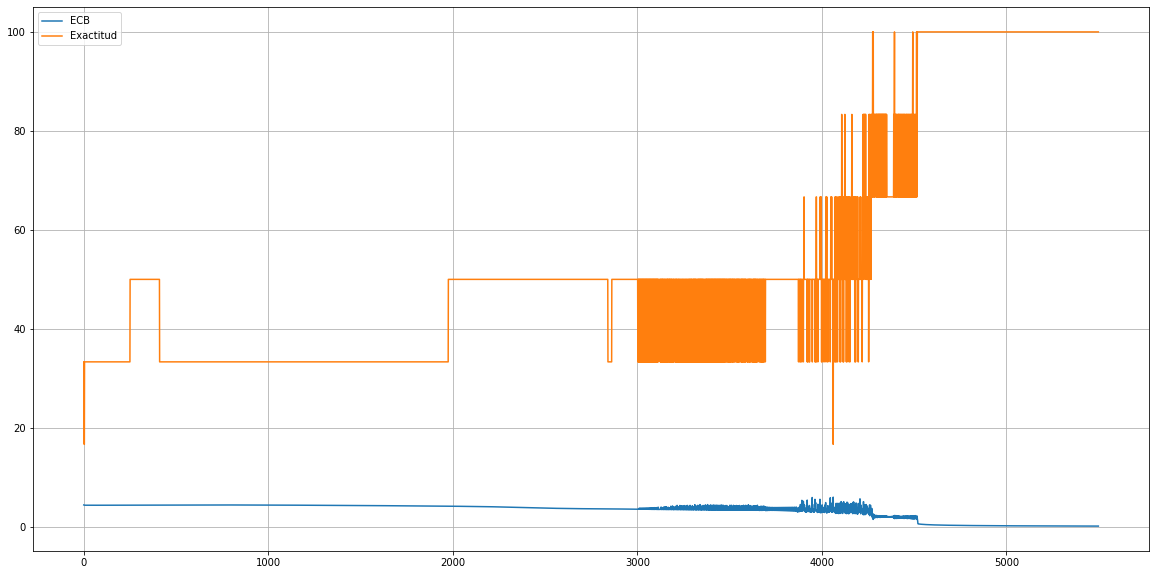

In [86]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

## 3. Regresión lineal con PyTorch
---

Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que considere los dos atributos de entrada.


* Especificaciones
  * Grafica los datos en 3D.
  * Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
  * Prueba distintos valores para los hiperparámetros.
  * Realiza una predicción con tu modelo entrenado para la calificación que tendría un alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación.
  * Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.





In [10]:
# TODO

## 4. Red completamente conectada con PyTorch

---



Implementa una red completamente conectada para la tarea de clasificación de imagenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguientes consideraciones:

* Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
* Discute tus resultados con las distintas configuraciones.

In [11]:
# TODO